In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path

import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

from tensorflow.keras import layers, regularizers, optimizers

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

2023-08-08 22:01:56.527108: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 22:01:56.576223: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 22:01:56.577001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 22:01:57.466602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds = xr.open_dataset('/home/jovyan/shared/data/finalized/sst.nc')

ds['time'] = ds['time'].dt.floor('D')

zarr_new = ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds = zarr_ds.sortby('time')

zarr_ds

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 149, lon: 181)
Coordinates:
  * lon      (lon) float32 45.0 45.25 45.5 45.75 46.0 ... 89.25 89.5 89.75 90.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 31.0 ... -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... 301.2 301.2 301.1
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [4]:
import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)

# processed_data = preprocess_data(zarr_ds).compute()
processed_data = preprocess_data(zarr_ds)
processed_data

def prepare_data_from_processed(processed_data, window_size=5): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y

X, y = prepare_data_from_processed(processed_data)

In [5]:
def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    # Compute end indices for each split
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D

def create_simple_model(input_shape=(5, 149, 181, 1)):
    model = Sequential()

    # ConvLSTM layer
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                         input_shape=input_shape,
                         padding='same', return_sequences=False))
    model.add(BatchNormalization())
    
    # Conv2D layer for output
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

model = create_simple_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 149, 181, 32)      38144     
                                                                 
 batch_normalization (Batch  (None, 149, 181, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 149, 181, 1)       289       
                                                                 
Total params: 38561 (150.63 KB)
Trainable params: 38497 (150.38 KB)
Non-trainable params: 64 (256.00 Byte)
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stop])

2023-08-08 22:04:41.204163: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2894313080 exceeds 10% of free system memory.
2023-08-08 22:04:47.906535: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2894313080 exceeds 10% of free system memory.


Epoch 1/20
168/168 [==============================] - 1234s 7s/step - loss: 0.0582 - mse: 0.0582 - val_loss: 1.2088 - val_mse: 1.2088
Epoch 2/20
168/168 [==============================] - 1232s 7s/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.6012 - val_mse: 0.6012
Epoch 3/20
168/168 [==============================] - 1230s 7s/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.1813 - val_mse: 0.1813
Epoch 4/20
168/168 [==============================] - 1228s 7s/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0469 - val_mse: 0.0469
Epoch 5/20
168/168 [==============================] - 1230s 7s/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 6/20
168/168 [==============================] - 1226s 7s/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 7/20
168/168 [==============================] - 1229s 7s/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 8/20
168/168 [==============================] - 1231s 7s

In [8]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    land_mask = np.load('land_mask.npy')
    # Set those positions in the prediction to NaN
    prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['sst'][time_index].values
    print(input_data_raw.shape)
    print(true_output_raw.shape)
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    print(prediction_postprocessed.shape)
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        input_data_raw = input_data_raw[..., np.newaxis]
        true_output_raw = true_output_raw[np.newaxis, ..., np.newaxis]
        prediction_postprocessed = prediction_postprocessed[np.newaxis, ...]
        
        all_data = np.concatenate([input_data_raw, prediction_postprocessed, true_output_raw])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title=''):
            sample_2d = np.squeeze(sample)
            plt.imshow(sample_2d, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.title(title)
            plt.colorbar()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})')
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})')

    return input_data_raw, prediction_postprocessed, true_output_raw

In [9]:
def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

(5, 149, 181)
(149, 181)
1/1 [==============================] - 0s 246ms/step
(149, 181, 1)


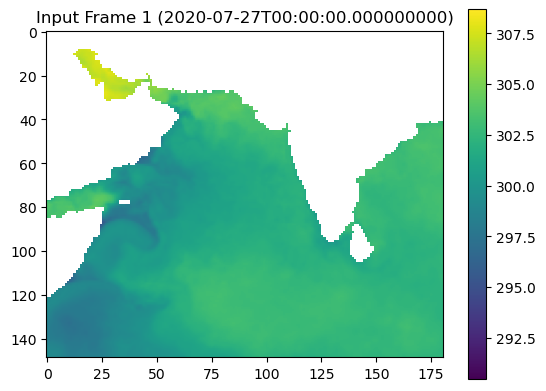

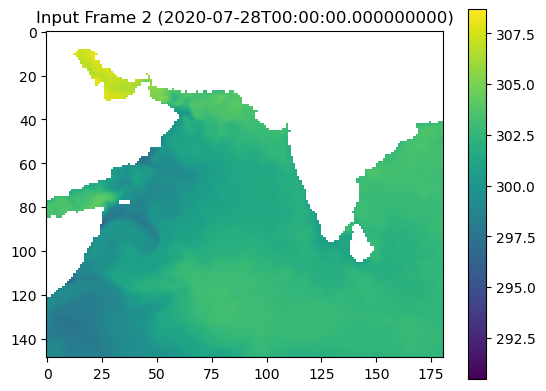

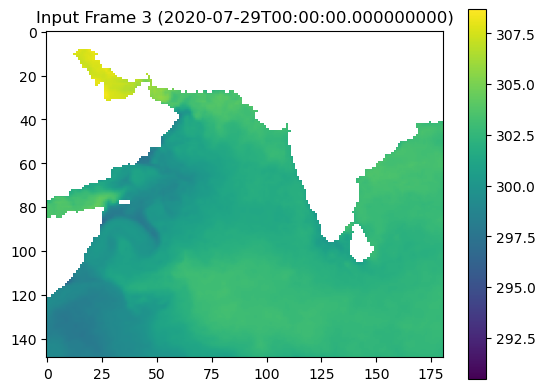

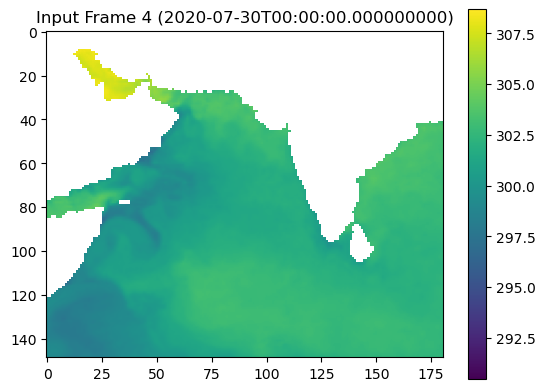

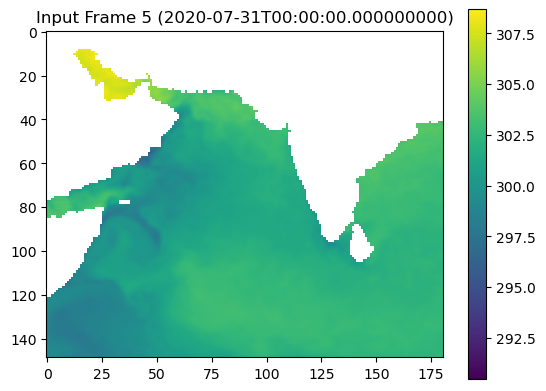

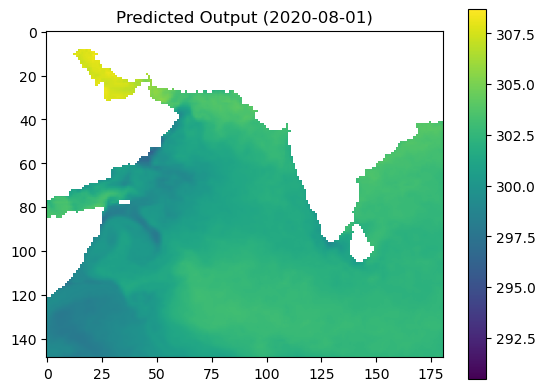

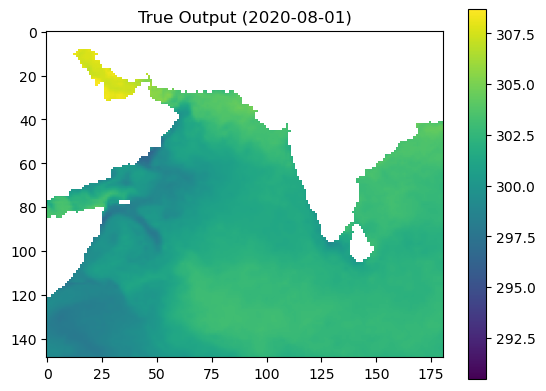

MAE between Predicted Output and True Output: 0.15578871965408325
MAE between Last Input Frame and True Output: 0.143082395195961


In [10]:
date_to_predict = '2020-08-01'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, zarr_ds)

predicted_mae = compute_mae(true_output, predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

last_input_frame = input_data[-1]
last_input_frame_2d = np.squeeze(last_input_frame)
true_output_2d = np.squeeze(true_output)
last_frame_mae = compute_mae(true_output_2d, last_input_frame_2d)
print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")

In [12]:
model.save('ConvLSTM_nc_2000-2020.keras')